In [483]:
#Packages
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras_tuner as kt
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate, Dropout, Add
from keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [428]:
import warnings

#Suppress the specific Keras warning
warnings.filterwarnings('ignore', category=UserWarning, message='The structure of `inputs` doesn\'t match the expected structure:')

In [331]:
#Set the display options to show all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [332]:
#Load users, movies, and ratings data
users = pd.read_csv('C:/Datasets/users.dat', sep='::', header=None, engine='python', encoding='latin-1', names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'])
movies = pd.read_csv('C:/Datasets/movies.dat', sep='::', header=None, engine='python', encoding='latin-1', names=['MovieID', 'Title', 'Genres'])
ratings = pd.read_csv('C:/Datasets/ratings.dat', sep='::', header=None, engine='python', encoding='latin-1', names=['UserID', 'MovieID', 'Rating', 'Timestamp'])

#Merge datasets to form a complete main dataset
df = pd.merge(pd.merge(ratings, users), movies)

In [333]:
#Dimensions of the dataset
df.shape

(1000209, 10)

In [334]:
#Removes duplicates
df.drop_duplicates()
#Verify if duplicate rows were dropped
df.shape

(1000209, 10)

In [335]:
#Identifies NULLS/missing values in each column
df.isnull().sum()

UserID        0
MovieID       0
Rating        0
Timestamp     0
Gender        0
Age           0
Occupation    0
Zip-code      0
Title         0
Genres        0
dtype: int64

In [336]:
#Summary of every features data type
df.dtypes

UserID         int64
MovieID        int64
Rating         int64
Timestamp      int64
Gender        object
Age            int64
Occupation     int64
Zip-code      object
Title         object
Genres        object
dtype: object

In [337]:
#Convert to float data type
df['Rating'] = df['Rating'].astype(float)  

In [338]:
#Normalize ratings to a 0-1 range
df['Rating'] = df['Rating'] / 5.0  

In [339]:
#Dropping irrelevant columns
df.drop('Timestamp',axis=1,inplace=True) 
df.drop('Title',axis=1,inplace=True) 

In [340]:
#Initialize separate encoders for each categorical feature
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
gender_encoder = LabelEncoder()
occupation_encoder = LabelEncoder()
zipcode_encoder = LabelEncoder()

#Apply encoding separately to each feature
df['UserID'] = user_encoder.fit_transform(df['UserID'])
df['MovieID'] = movie_encoder.fit_transform(df['MovieID'])
df['Gender'] = gender_encoder.fit_transform(df['Gender'])
df['Occupation'] = occupation_encoder.fit_transform(df['Occupation'])
df['Zip-code'] = zipcode_encoder.fit_transform(df['Zip-code'])

In [341]:
#Split and one-hot encode Genres
df['Genres'] = df['Genres'].apply(lambda x: x.split('|'))
mlb = MultiLabelBinarizer()
df[mlb.classes_] = mlb.fit_transform(df['Genres'])

#Drop Genres
df.drop('Genres',axis=1,inplace=True) 

In [343]:
#Split data into train and test sets (80-20)
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

In [344]:
#Split train/test data into inputs and target for NCF and Matrix Factorization models
X_train = train_data[['UserID', 'MovieID']]
y_train = train_data['Rating']

X_test = test_data[['UserID', 'MovieID']]
y_test = test_data['Rating']

In [345]:
#List of Genres columns
genre_columns = mlb.classes_

#Split train/test data into inputs and target for the Hybrid model
X_train_hybrid = train_data[['UserID', 'MovieID', 'Gender', 'Age', 'Occupation', 'Zip-code'] + list(genre_columns)]
y_train_hybrid = train_data['Rating']

X_test_hybrid = test_data[['UserID', 'MovieID', 'Gender', 'Age', 'Occupation', 'Zip-code'] + list(genre_columns)]
y_test_hybrid = test_data['Rating']

In [429]:
#Determine the actual number of movies based on the max MovieID after encoding
num_movies = df['MovieID'].max() + 1  #3705 + 1 = 3706
num_users = df['UserID'].max() + 1  #Ensure the embedding covers all users

#Set the embedding size 
embedding_size = 50

#Define input layers for UserID and MovieID
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')

#Embedding layers for users and movies
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)
movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_size, name='movie_embedding')(movie_input)

#Flatten the embeddings to convert them into dense vectors
user_vec = Flatten()(user_embedding)
movie_vec = Flatten()(movie_embedding)

#Concatenate the embeddings
concat = Concatenate()([user_vec, movie_vec])

#Add Dense layers for non-linear interactions
dense = Dense(128, activation='relu')(concat)
dense = Dropout(0.2)(dense)  # Dropout to prevent overfitting
dense = Dense(64, activation='relu')(dense)

#Output layer (predicting the rating)
output = Dense(1, activation='linear')(dense)

#Build the NFC model
ncf_model = Model([user_input, movie_input], output)

#Compile the model
ncf_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Train the NCF model
ncf_history = ncf_model.fit(
    [X_train['UserID'], X_train['MovieID']],  #Inputs (UserID and MovieID)
    y_train,  #Target (ratings)
    epochs=10,  
    batch_size=64,  
    validation_data=([X_test['UserID'], X_test['MovieID']], y_test)  #Validation set
)

Epoch 1/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0419 - mae: 0.1598 - val_loss: 0.0335 - val_mae: 0.1455
Epoch 2/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0323 - mae: 0.1417 - val_loss: 0.0320 - val_mae: 0.1413
Epoch 3/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 13s 1000us/step - loss: 0.0308 - mae: 0.1380 - val_loss: 0.0313 - val_mae: 0.1387
Epoch 4/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 12s 993us/step - loss: 0.0297 - mae: 0.1352 - val_loss: 0.0309 - val_mae: 0.1388
Epoch 5/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 12s 996us/step - loss: 0.0287 - mae: 0.1329 - val_loss: 0.0306 - val_mae: 0.1375
Epoch 6/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0278 - mae: 0.1306 - val_loss: 0.0305 - val_mae: 0.1378
Epoch 7/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0269 - mae: 0.1284 - val_loss: 0.0305 - val_mae: 0.1376
Epoch 8/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0259 - mae: 0.1259 - val_loss: 0.0305 - val_mae: 0.1373
Epoch 9/1

In [430]:
#Ensure the embedding range covers all movies/users
num_movies = df['MovieID'].max() + 1   
num_users = df['UserID'].max() + 1  

#Set the embedding size 
embedding_size = 50  

#Define input layers for UserID and MovieID
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')

#Embedding layers for users and movies
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)
movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_size, name='movie_embedding')(movie_input)

#Flatten the embeddings to convert them into dense vectors
user_vec = Flatten(name='flatten_user')(user_embedding)
movie_vec = Flatten(name='flatten_movie')(movie_embedding)

#Dot product between the user and movie embeddings (latent factor interaction)
dot_product = Dot(axes=1)([user_vec, movie_vec]) 

#Bias terms (to capture the average rating for users and movies)
user_bias = Embedding(input_dim=num_users, output_dim=1, name='user_bias')(user_input)
movie_bias = Embedding(input_dim=num_movies, output_dim=1, name='movie_bias')(movie_input)
user_bias = Flatten(name='flatten_user_bias')(user_bias)
movie_bias = Flatten(name='flatten_movie_bias')(movie_bias)

#Add the bias terms to the dot product
prediction = Add()([dot_product, user_bias, movie_bias])

#Build the Matrix Factorization model
matrix_factorization_model = Model([user_input, movie_input], prediction)

#Compile the model
matrix_factorization_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Train the Matrix Factorization model
matrix_factorization_history = matrix_factorization_model.fit(
    [X_train['UserID'], X_train['MovieID']],  #Inputs (UserID and MovieID)
    y_train,  #Target (ratings)
    epochs=10,  
    batch_size=64, 
    validation_data=([X_test['UserID'], X_test['MovieID']], y_test)  #Validation set
)

Epoch 1/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 12s 886us/step - loss: 0.1558 - mae: 0.3007 - val_loss: 0.0343 - val_mae: 0.1458
Epoch 2/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 11s 883us/step - loss: 0.0291 - mae: 0.1339 - val_loss: 0.0341 - val_mae: 0.1450
Epoch 3/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 11s 890us/step - loss: 0.0234 - mae: 0.1196 - val_loss: 0.0358 - val_mae: 0.1481
Epoch 4/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 11s 877us/step - loss: 0.0208 - mae: 0.1123 - val_loss: 0.0374 - val_mae: 0.1509
Epoch 5/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 11s 868us/step - loss: 0.0195 - mae: 0.1087 - val_loss: 0.0387 - val_mae: 0.1533
Epoch 6/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 11s 867us/step - loss: 0.0187 - mae: 0.1063 - val_loss: 0.0398 - val_mae: 0.1549
Epoch 7/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 11s 866us/step - loss: 0.0183 - mae: 0.1053 - val_loss: 0.0407 - val_mae: 0.1565
Epoch 8/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 11s 884us/step - loss: 0.0180 - mae: 0.1040 - val_loss: 0.0415 - val_mae: 0.1580


In [440]:
#Ensure the embedding range covers all movies/users
num_movies = df['MovieID'].max() + 1  
num_users = df['UserID'].max() + 1  

#Embedding size
embedding_size = 50

#Input layers for additional features
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')
age_input = Input(shape=(1,), name='age_input')
gender_input = Input(shape=(1,), name='gender_input')
occupation_input = Input(shape=(1,), name='occupation_input')
zip_input = Input(shape=(1,), name='zip_input')
genres_input = Input(shape=(len(genre_columns),), name='genres_input')

#Embedding layers for users and movies
user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)
movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_size, name='movie_embedding')(movie_input)

#Flatten the embeddings to convert them into dense vectors
user_vec = Flatten()(user_embedding)
movie_vec = Flatten()(movie_embedding)

#Concatenate embeddings with additional features
user_features = Concatenate()([user_vec, age_input, gender_input, occupation_input, zip_input])
movie_features = Concatenate()([movie_vec, genres_input])

#Combine user and movie features
combined_features = Concatenate()([user_features, movie_features])

#Dense layers for non-linear interactions
dense = Dense(128, activation='relu')(combined_features)
dense = Dropout(0.2)(dense)  # Dropout to prevent overfitting
dense = Dense(64, activation='relu')(dense)

#Output layer (predicting the rating)
output = Dense(1, activation='linear')(dense)

#Build the hybrid model
hybrid_model = Model([user_input, movie_input, age_input, gender_input, occupation_input, zip_input, genres_input], output)

#Compile the model
hybrid_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#Train the Hybrid model
hybrid_history = hybrid_model.fit(
    [X_train_hybrid['UserID'], X_train_hybrid['MovieID'], X_train_hybrid['Age'], X_train_hybrid['Gender'], 
     X_train_hybrid['Occupation'], X_train_hybrid['Zip-code'], X_train_hybrid[genre_columns]],  #Inputs
    y_train_hybrid,  # Target (ratings)
    epochs=10, 
    batch_size=64,  
    validation_data=([X_test_hybrid['UserID'], X_test_hybrid['MovieID'], X_test_hybrid['Age'], X_test_hybrid['Gender'], 
                      X_test_hybrid['Occupation'], X_test_hybrid['Zip-code'], X_test_hybrid[genre_columns]], y_test_hybrid)
)

Epoch 1/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 105.0191 - mae: 2.8019 - val_loss: 0.0388 - val_mae: 0.1613
Epoch 2/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0448 - mae: 0.1659 - val_loss: 0.0336 - val_mae: 0.1450
Epoch 3/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.0351 - mae: 0.1487 - val_loss: 0.0333 - val_mae: 0.1454
Epoch 4/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.0336 - mae: 0.1453 - val_loss: 0.0332 - val_mae: 0.1447
Epoch 5/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.0328 - mae: 0.1430 - val_loss: 0.0332 - val_mae: 0.1461
Epoch 6/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 0.0322 - mae: 0.1418 - val_loss: 0.0345 - val_mae: 0.1513
Epoch 7/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 0.0319 - mae: 0.1409 - val_loss: 0.0327 - val_mae: 0.1424
Epoch 8/10
12503/12503 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.0320 - mae: 0.1410 - val_loss: 0.0330 - val_mae: 0.1438
Epoch 9/10
125

In [445]:
#Helper function for Precision@K
def precision_at_k(actual, predicted, k):
    """Calculates Precision@K."""
    predicted_at_k = predicted[:k]  #Top K predictions
    relevant_at_k = len(set(actual).intersection(predicted_at_k))  #Relevant items in Top K
    return relevant_at_k / k if k > 0 else 0

#Helper function for Recall@K
def recall_at_k(actual, predicted, k):
    """Calculates Recall@K."""
    predicted_at_k = predicted[:k]  # Top K predictions
    relevant_at_k = len(set(actual).intersection(predicted_at_k))  #Relevant items in Top K
    return relevant_at_k / len(actual) if len(actual) > 0 else 0

#Helper function for NDCG@K
def ndcg_at_k(actual, predicted, k):
    """Calculates NDCG@K."""
    def dcg_at_k(actual, predicted, k):
        predicted_at_k = predicted[:k]  #Top K predictions
        gain = [1 if i in actual else 0 for i in predicted_at_k]  #Binary gain: 1 if relevant
        discounts = [np.log2(i + 2) for i in range(len(gain))]  #Log2 discounts
        return np.sum([g / d for g, d in zip(gain, discounts)])
    
    ideal_dcg = dcg_at_k(actual, actual, k)  #Ideal DCG is when ranking is perfect
    actual_dcg = dcg_at_k(actual, predicted, k)
    return actual_dcg / ideal_dcg if ideal_dcg > 0 else 0

#Main evaluation function
def evaluate(model, X_test, y_test, k=5, threshold=0.8, model_type='ncf'):
    """
    Evaluate the model using RMSE, MAE, Precision@K, Recall@K, and NDCG on the test data.
    """
 
    print("Test Result:\n======================================================")   
    print(f"Evaluating Model Type: {model_type}")

    #Ensure that for hybrid models, we pass all the 7 inputs correctly
    if model_type == 'hybrid':
        pred_test = model.predict([
            X_test[0], X_test[1], X_test[2], X_test[3], X_test[4], X_test[5], X_test[6]
        ])  #Pass all inputs for hybrid model
    else:
        #For NCF and Matrix Factorization models
        pred_test = model.predict([X_test[0], X_test[1]])  
    
    #Convert y_test to NumPy array
    y_test = np.array(y_test)

    #Calculate RMSE and MAE for testing data
    test_rmse = np.sqrt(mean_squared_error(y_test, pred_test))
    test_mae = mean_absolute_error(y_test, pred_test)

    print("Root Mean Squared Error: {:.2f}".format(test_rmse))
    print("Mean Absolute Error: {:.2f}".format(test_mae))

    #Calculate Precision@K, Recall@K, and NDCG@K
    precision_list, recall_list, ndcg_list = [], [], []
    
    #Loop over each user in the test set to calculate Precision@K, Recall@K, and NDCG@K
    for idx in range(len(y_test)):
        #Calculate indices of relevant movies based on threshold
        actual_ratings = np.where(y_test[idx] >= threshold)[0]  #Indices of relevant movies
        
        #Predicted ratings sorted and top K taken
        predicted_ratings = np.argsort(pred_test[idx])[::-1]  #Sort predicted ratings in descending order
        top_k_predicted = predicted_ratings[:k]  #Get the top K predicted ratings

        #Calculate precision, recall, and NDCG
        precision_list.append(precision_at_k(actual_ratings, top_k_predicted, k))
        recall_list.append(recall_at_k(actual_ratings, top_k_predicted, k))
        ndcg_list.append(ndcg_at_k(actual_ratings, top_k_predicted, k))
    
    avg_precision_at_k = np.mean(precision_list)
    avg_recall_at_k = np.mean(recall_list)
    avg_ndcg_at_k = np.mean(ndcg_list)
    
    print(f"Precision@{k}: {avg_precision_at_k:.4f}")
    print(f"Recall@{k}: {avg_recall_at_k:.4f}")
    print(f"NDCG@{k}: {avg_ndcg_at_k:.4f}")
    print("_____________________________________________________")
    print()
    
    #Return metrics for further use
    return test_rmse, test_mae, avg_precision_at_k, avg_recall_at_k, avg_ndcg_at_k

In [446]:
#Evaluate NCF Model
rmse_ncf, mae_ncf, precision_ncf, recall_ncf, ndcg_ncf = evaluate(
    model=ncf_model,  #trained NCF model
    X_test=[X_test['UserID'], X_test['MovieID']],  #Inputs (UserID and MovieID) for testing
    y_test=y_test,  #Actual ratings 
    k=5,  #Precision@K, Recall@K, NDCG@K
    threshold=0.8, #0.8 (equivalent to rating >= 4 on original scale)
    model_type='ncf'
)

Test Result:
Evaluating Model Type: ncf
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 4s 613us/step
Root Mean Squared Error: 0.18
Mean Absolute Error: 0.14
Precision@5: 0.1153
Recall@5: 0.5767
NDCG@5: 0.5767
_____________________________________________________



In [447]:
#Evaluate Matrix Factorization Model
rmse_mf, mae_mf, precision_mf, recall_mf, ndcg_mf = evaluate(
    model=matrix_factorization_model,  #trained Matrix Factorization model
    X_test=[X_test['UserID'], X_test['MovieID']],  #Inputs (UserID and MovieID) for testing
    y_test=y_test,  #Actual ratings 
    k=5,  #Precision@K, Recall@K, NDCG@K
    threshold=0.8,  #0.8 (equivalent to rating >= 4 on original scale)
    model_type='matrix_factorization'
)

Test Result:
Evaluating Model Type: matrix_factorization
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 4s 627us/step
Root Mean Squared Error: 0.21
Mean Absolute Error: 0.16
Precision@5: 0.1153
Recall@5: 0.5767
NDCG@5: 0.5767
_____________________________________________________



In [448]:
#Evaluate Hybrid Model
rmse_hybrid, mae_hybrid, precision_hybrid, recall_hybrid, ndcg_hybrid = evaluate(
    model=hybrid_model,  #trained Hybrid model
    X_test=[
        X_test_hybrid['UserID'], X_test_hybrid['MovieID'], X_test_hybrid['Age'], 
        X_test_hybrid['Gender'], X_test_hybrid['Occupation'], X_test_hybrid['Zip-code'], 
        X_test_hybrid[genre_columns]
    ],  #Inputs (UserID, MovieID, and additional features) for testing
    y_test=y_test_hybrid,  #Actual ratings
    k=5,  # Precision@K, Recall@K, NDCG@K
    threshold=0.8,  #0.8 (equivalent to rating >= 4 on original scale)
    model_type='hybrid'
)

Test Result:
Evaluating Model Type: hybrid
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 5s 794us/step
Root Mean Squared Error: 0.18
Mean Absolute Error: 0.14
Precision@5: 0.1153
Recall@5: 0.5767
NDCG@5: 0.5767
_____________________________________________________



In [455]:
#Store results in lists
rmse_list = [round(rmse_ncf, 2), round(rmse_mf, 2), round(rmse_hybrid, 2)]
mae_list = [round(mae_ncf, 2), round(mae_mf, 2), round(mae_hybrid, 2)]
precision_list = [round(precision_ncf, 2), round(precision_mf, 2), round(precision_hybrid, 2)]
recall_list = [round(recall_ncf, 2), round(recall_mf, 2), round(recall_hybrid, 2)]
ndcg_list = [round(ndcg_ncf, 2), round(ndcg_mf, 2), round(ndcg_hybrid, 2)]

#Create df to store the results
model_scores = {
    'RMSE': rmse_list,
    'MAE': mae_list,
    'Precision@K': precision_list,
    'Recall@K': recall_list,
    'NDCG@K': ndcg_list
}

models_df = pd.DataFrame(model_scores, index=['NCF', 'Matrix Factorization', 'Hybrid'])

#Display results
models_df.head()

,RMSE,MAE,Precision@K,Recall@K,NDCG@K
NCF,0.18,0.14,0.12,0.58,0.58
Matrix Factorization,0.21,0.16,0.12,0.58,0.58
Hybrid,0.18,0.14,0.12,0.58,0.58


In [481]:
#Hyperparameter tune NCF model 
def build_ncf_model(hp):
    #Choose embedding size as a tunable parameter
    embedding_size = hp.Int('embedding_size', min_value=16, max_value=128, step=16)
    
    #Define input layers for UserID and MovieID
    user_input = Input(shape=(1,), name='user_input')
    movie_input = Input(shape=(1,), name='movie_input')
    
    #Embedding layers for users and movies
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)
    movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_size, name='movie_embedding')(movie_input)
    
    #Flatten the embeddings to convert them into dense vectors
    user_vec = Flatten()(user_embedding)
    movie_vec = Flatten()(movie_embedding)
    
    #Concatenate the embeddings
    concat = Concatenate()([user_vec, movie_vec])
    
    #Add tunable number of Dense layers with variable units and L2 regularization
    dense = Dense(hp.Int('units', min_value=32, max_value=256, step=32), 
                  activation=hp.Choice('activation', values=['relu', 'tanh']),
                  kernel_regularizer=l2(hp.Float('l2', min_value=1e-5, max_value=1e-2, sampling='LOG')))(concat)
    
    #Add Dropout layer with a tunable dropout rate
    dense = Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1))(dense)
    
    #Additional Dense layer with L2 regularization
    dense = Dense(hp.Int('units_2', min_value=32, max_value=256, step=32), 
                  activation=hp.Choice('activation_2', values=['relu', 'tanh']),
                  kernel_regularizer=l2(hp.Float('l2_2', min_value=1e-5, max_value=1e-2, sampling='LOG')))(dense)
    
    #Output layer (predicting the rating)
    output = Dense(1, activation='linear')(dense)
    
    #Build the model
    model = Model([user_input, movie_input], output)
    
    #Compile the model with a tunable learning rate, optimizing for MAE
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')), 
                  loss='mae', metrics=['mae'])
    
    return model

#Define the Random Search tuner
tuner = kt.RandomSearch(
    build_ncf_model,
    objective='val_mae',  #Optimize for validation MAE
    max_trials=5,  #How many different combinations to try
    executions_per_trial=1,  #Number of times to evaluate each model
    directory='ncf_tuner',  #Directory to save models
    project_name='ncf_random_search')

#Hyperparameter tuning 
tuner.search([X_train['UserID'], X_train['MovieID']], y_train, 
             epochs=20,  
             batch_size=32,   
             validation_data=([X_test['UserID'], X_test['MovieID']], y_test))

#Get the best model from tuning
best_ncf_model = tuner.get_best_models(num_models=1)[0]

Trial 5 Complete [00h 06m 59s]
val_mae: 0.14248627424240112

Best val_mae So Far: 0.1334649622440338
Total elapsed time: 00h 49m 40s


C:\Users\Danny\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [484]:
#Evaluate the tuned NCF model
rmse_ncf_tuned, mae_ncf_tuned, precision_ncf_tuned, recall_ncf_tuned, ndcg_ncf_tuned = evaluate(
    model=best_ncf_model,  #Tuned NCF model from tuner
    X_test=[X_test['UserID'], X_test['MovieID']],  #Inputs (UserID and MovieID) for testing
    y_test=y_test,  #Actual ratings
    k=5,  #Precision@K, Recall@K, NDCG@K
    threshold=0.8,  #0.8 (equivalent to rating >= 4 on original scale)
    model_type='ncf'
)

Test Result:
Evaluating Model Type: ncf
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 4s 621us/step
Root Mean Squared Error: 0.19
Mean Absolute Error: 0.13
Precision@5: 0.1153
Recall@5: 0.5767
NDCG@5: 0.5767
_____________________________________________________



In [485]:
#Hyperparameter tune Matrix Factorization model
def build_mf_model(hp):
    #Choose embedding size as a tunable parameter (like NCF)
    embedding_size = hp.Int('embedding_size', min_value=16, max_value=128, step=16)
    
    #Define input layers for UserID and MovieID
    user_input = Input(shape=(1,), name='user_input')
    movie_input = Input(shape=(1,), name='movie_input')
    
    #Embedding layers for users and movies
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)
    movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_size, name='movie_embedding')(movie_input)
    
    #Flatten the embeddings to convert them into dense vectors
    user_vec = Flatten(name='flatten_user')(user_embedding)
    movie_vec = Flatten(name='flatten_movie')(movie_embedding)
    
    #Dot product between the user and movie embeddings (latent factor interaction)
    dot_product = Dot(axes=1)([user_vec, movie_vec])  # Dot product captures the interaction
    
    #Bias terms for users and movies
    user_bias = Embedding(input_dim=num_users, output_dim=1, name='user_bias')(user_input)
    movie_bias = Embedding(input_dim=num_movies, output_dim=1, name='movie_bias')(movie_input)
    
    #Flatten the bias terms
    user_bias = Flatten(name='flatten_user_bias')(user_bias)
    movie_bias = Flatten(name='flatten_movie_bias')(movie_bias)
    
    #Add the bias terms to the dot product
    prediction = Add()([dot_product, user_bias, movie_bias])
    
    #Build the model
    model = Model([user_input, movie_input], prediction)
    
    #Compile the model with a tunable learning rate and L2 regularization
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mae', metrics=['mae'])  

    return model

#Define the Random Search tuner for Matrix Factorization
tuner_mf = kt.RandomSearch(
    build_mf_model,
    objective='val_mae',  #Optimize for validation MAE
    max_trials=5,  #How many different combinations to try
    executions_per_trial=1,  #Number of times to evaluate each model
    directory='mf_tuner',  #Directory to save models
    project_name='mf_random_search')

#Hyperparameter tuning
tuner_mf.search([X_train['UserID'], X_train['MovieID']], y_train,
                epochs=20,  
                batch_size=32,  
                validation_data=([X_test['UserID'], X_test['MovieID']], y_test))

#Get the best model from tuning
best_mf_model = tuner_mf.get_best_models(num_models=1)[0]

Trial 5 Complete [00h 06m 31s]
val_mae: 0.13752888143062592

Best val_mae So Far: 0.13752888143062592
Total elapsed time: 00h 39m 50s


C:\Users\Danny\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [486]:
#Evaluate the tuned Matrix Factorization model
rmse_mf_tuned, mae_mf_tuned, precision_mf_tuned, recall_mf_tuned, ndcg_mf_tuned = evaluate(
    model=best_mf_model,  #Tuned MF model from tuner
    X_test=[X_test['UserID'], X_test['MovieID']], #Inputs (UserID and MovieID) for testing
    y_test=y_test, #Actual ratings
    k=5, #Precision@K, Recall@K, NDCG@K
    threshold=0.8, #0.8 (equivalent to rating >= 4 on original scale)
    model_type='matrix_factorization'
)

Test Result:
Evaluating Model Type: matrix_factorization
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 4s 636us/step
Root Mean Squared Error: 0.18
Mean Absolute Error: 0.14
Precision@5: 0.1153
Recall@5: 0.5767
NDCG@5: 0.5767
_____________________________________________________



In [487]:
#Hyperparameter tuned Hybrid model
def build_hybrid_model(hp):
    #Choose embedding size as a tunable parameter
    embedding_size = hp.Int('embedding_size', min_value=16, max_value=128, step=16)
    
    #Define input layers for UserID, MovieID, and additional features (e.g., age, gender, occupation)
    user_input = Input(shape=(1,), name='user_input')
    movie_input = Input(shape=(1,), name='movie_input')
    age_input = Input(shape=(1,), name='age_input')
    gender_input = Input(shape=(1,), name='gender_input')
    occupation_input = Input(shape=(1,), name='occupation_input')
    zip_input = Input(shape=(1,), name='zip_input')
    genres_input = Input(shape=(len(genre_columns),), name='genres_input')  
    
    #Embedding layers for users and movies
    user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)
    movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_size, name='movie_embedding')(movie_input)
    
    #Flatten the embeddings to convert them into dense vectors
    user_vec = Flatten()(user_embedding)
    movie_vec = Flatten()(movie_embedding)
    
    #Concatenate embeddings with additional user and movie features
    user_features = Concatenate()([user_vec, age_input, gender_input, occupation_input, zip_input])
    movie_features = Concatenate()([movie_vec, genres_input])
    
    #Combine user and movie features
    combined_features = Concatenate()([user_features, movie_features])
    
    #Add tunable number of Dense layers with L2 regularization
    dense = Dense(hp.Int('units', min_value=32, max_value=256, step=32), 
                  activation=hp.Choice('activation', values=['relu', 'tanh']),
                  kernel_regularizer=l2(hp.Float('l2', min_value=1e-5, max_value=1e-2, sampling='LOG')))(combined_features)
    
    #Add Dropout layer with a tunable dropout rate
    dense = Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1))(dense)
    
    #Additional Dense layer with L2 regularization
    dense = Dense(hp.Int('units_2', min_value=32, max_value=256, step=32), 
                  activation=hp.Choice('activation_2', values=['relu', 'tanh']),
                  kernel_regularizer=l2(hp.Float('l2_2', min_value=1e-5, max_value=1e-2, sampling='LOG')))(dense)
    
    #Output layer (predicting the rating)
    output = Dense(1, activation='linear')(dense)
    
    #Build the model
    model = Model([user_input, movie_input, age_input, gender_input, occupation_input, zip_input, genres_input], output)
    
    #Compile the model with a tunable learning rate, optimizing for MAE
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')), 
                  loss='mae', metrics=['mae'])
    
    return model

#Define the Random Search tuner for the Hybrid model
tuner_hybrid = kt.RandomSearch(
    build_hybrid_model,
    objective='val_mae',  # Optimize for validation MAE
    max_trials=5,  # How many different combinations to try
    executions_per_trial=1,  # Number of times to evaluate each model
    directory='hybrid_tuner',  # Directory to save models
    project_name='hybrid_random_search')

#Hyperparameter tuning
tuner_hybrid.search([X_train_hybrid['UserID'], X_train_hybrid['MovieID'], X_train_hybrid['Age'], X_train_hybrid['Gender'],
                     X_train_hybrid['Occupation'], X_train_hybrid['Zip-code'], X_train_hybrid[genre_columns]], y_train_hybrid,
                    epochs=20,  
                    batch_size=32,  
                    validation_data=([X_test_hybrid['UserID'], X_test_hybrid['MovieID'], X_test_hybrid['Age'], X_test_hybrid['Gender'], 
                                      X_test_hybrid['Occupation'], X_test_hybrid['Zip-code'], X_test_hybrid[genre_columns]], y_test_hybrid))

#Get the best model from tuning
best_hybrid_model = tuner_hybrid.get_best_models(num_models=1)[0]

Trial 5 Complete [00h 08m 14s]
val_mae: 0.1739991456270218

Best val_mae So Far: 0.144797220826149
Total elapsed time: 00h 54m 58s


C:\Users\Danny\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [488]:
#Evaluate the tuned Hybrid model
rmse_hybrid_tuned, mae_hybrid_tuned, precision_hybrid_tuned, recall_hybrid_tuned, ndcg_hybrid_tuned = evaluate(
    model=best_hybrid_model,  # Tuned Hybrid model from tuner
    X_test=[X_test_hybrid['UserID'], X_test_hybrid['MovieID'], X_test_hybrid['Age'], 
            X_test_hybrid['Gender'], X_test_hybrid['Occupation'], X_test_hybrid['Zip-code'], 
            X_test_hybrid[genre_columns]], #Inputs (UserID, MovieID, and additional features) for testing
    y_test=y_test_hybrid, #Actual ratings
    k=5, #Precision@K, Recall@K, NDCG@K
    threshold=0.8, #0.8 (equivalent to rating >= 4 on original scale)
    model_type='hybrid'
)

Test Result:
Evaluating Model Type: hybrid
6252/6252 ━━━━━━━━━━━━━━━━━━━━ 6s 893us/step
Root Mean Squared Error: 0.19
Mean Absolute Error: 0.14
Precision@5: 0.1153
Recall@5: 0.5767
NDCG@5: 0.5767
_____________________________________________________



In [497]:
#Store tuned results in lists
rmse_list_tuned = [round(rmse_ncf_tuned, 4), round(rmse_mf_tuned, 4), round(rmse_hybrid_tuned, 4)]
mae_list_tuned = [round(mae_ncf_tuned, 4), round(mae_mf_tuned, 4), round(mae_hybrid_tuned, 4)]
precision_list_tuned = [round(precision_ncf_tuned, 4), round(precision_mf_tuned, 4), round(precision_hybrid_tuned, 4)]
recall_list_tuned = [round(recall_ncf_tuned, 4), round(recall_mf_tuned, 4), round(recall_hybrid_tuned, 4)]
ndcg_list_tuned = [round(ndcg_ncf_tuned, 4), round(ndcg_mf_tuned, 4), round(ndcg_hybrid_tuned, 4)]

#Create a df to store the results of tuned models
tuned_model_scores = {
    'RMSE': rmse_list_tuned,
    'MAE': mae_list_tuned,
    'Precision@K': precision_list_tuned,
    'Recall@K': recall_list_tuned,
    'NDCG@K': ndcg_list_tuned
}

tuned_models_df = pd.DataFrame(tuned_model_scores, index=['NCF (Tuned)', 'Matrix Factorization (Tuned)', 'Hybrid (Tuned)'])

#Display results of tuned models
tuned_models_df.head()

,RMSE,MAE,Precision@K,Recall@K,NDCG@K
NCF (Tuned),0.1886,0.1335,0.1153,0.5767,0.5767
Matrix Factorization (Tuned),0.1779,0.1375,0.1153,0.5767,0.5767
Hybrid (Tuned),0.1949,0.1448,0.1153,0.5767,0.5767


In [503]:
#Store tuned results in lists
rmse_list_tuned = [round(rmse_ncf_tuned, 4), round(rmse_mf_tuned, 4), round(rmse_hybrid_tuned, 4)]
mae_list_tuned = [round(mae_ncf_tuned, 4), round(mae_mf_tuned, 4), round(mae_hybrid_tuned, 4)]
precision_list_tuned = [round(precision_ncf_tuned, 4), round(precision_mf_tuned, 4), round(precision_hybrid_tuned, 4)]
recall_list_tuned = [round(recall_ncf_tuned, 4), round(recall_mf_tuned, 4), round(recall_hybrid_tuned, 4)]
ndcg_list_tuned = [round(ndcg_ncf_tuned, 4), round(ndcg_mf_tuned, 4), round(ndcg_hybrid_tuned, 4)]

#Create a df to store the results of tuned models
tuned_model_scores = {
    'RMSE': rmse_list_tuned,
    'MAE': mae_list_tuned,
    'Precision@K': precision_list_tuned,
    'Recall@K': recall_list_tuned,
    'NDCG@K': ndcg_list_tuned
}

tuned_models_df = pd.DataFrame(tuned_model_scores, index=['NCF (Tuned)', 'Matrix Factorization (Tuned)', 'Hybrid (Tuned)'])

#Define colors for each row
colors = [
    'skyblue',
    'lightgreen',
    'lightcoral'
]

#Apply background colors to the DataFrame
styled_tuned_models_df = tuned_models_df.style.format("{:.4f}").apply(lambda x: [f'background-color: {colors[i]}' for i in range(len(tuned_models_df))], axis=0)

# Display the styled results
styled_tuned_models_df

,RMSE,MAE,Precision@K,Recall@K,NDCG@K
NCF (Tuned),0.1886,0.1335,0.1153,0.5767,0.5767
Matrix Factorization (Tuned),0.1779,0.1375,0.1153,0.5767,0.5767
Hybrid (Tuned),0.1949,0.1448,0.1153,0.5767,0.5767


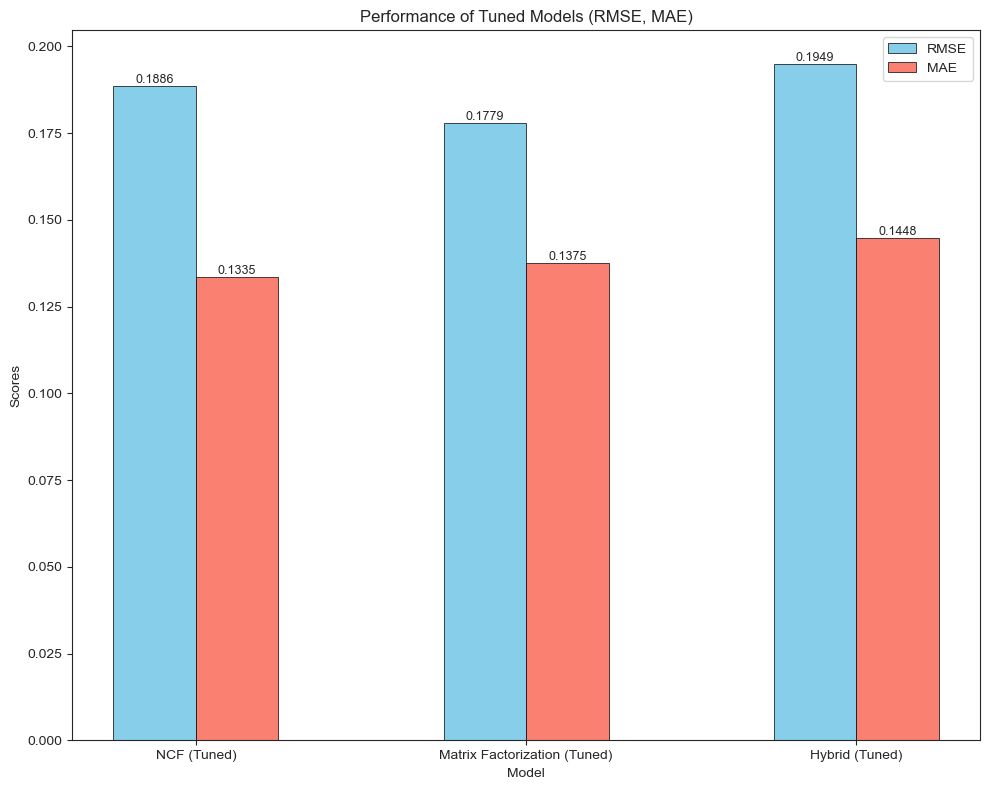

In [533]:
#Use the lists of RMSE and MAE from the stored results
rmse_scores = rmse_list_tuned
mae_scores = mae_list_tuned

#Define the models
models = ['NCF (Tuned)', 'Matrix Factorization (Tuned)', 'Hybrid (Tuned)']

#Set the width of the bars
bar_width = 0.25

#Set the position of the bars on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

#Grouped bar plot depicting model metric scores
plt.figure(figsize=(10, 8))
bars_rmse = plt.bar(r1, rmse_scores, color='skyblue', width=bar_width, edgecolor='black', linewidth=0.5, label='RMSE')
bars_mae = plt.bar(r2, mae_scores, color='salmon', width=bar_width, edgecolor='black', linewidth=0.5, label='MAE')

#Function to format RMSE and MAE scores for annotations
def format_scores(scores):
    return [f"{score:.4f}" for score in scores]

#Add annotations just above bars for RMSE and MAE scores
def add_labels(bars, scores):
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.0001, score, ha='center', va='bottom', fontsize=9)
               
#Annotate the bars
add_labels(bars_rmse, format_scores(rmse_scores))
add_labels(bars_mae, format_scores(mae_scores))

#Configure plot
plt.xlabel('Model')
plt.ylabel('Scores')
plt.xticks([r + bar_width / 2 for r in range(len(models))], models, ha='center')
plt.title('Performance of Tuned Models (RMSE, MAE)')
plt.legend()
plt.tight_layout()

plt.show()

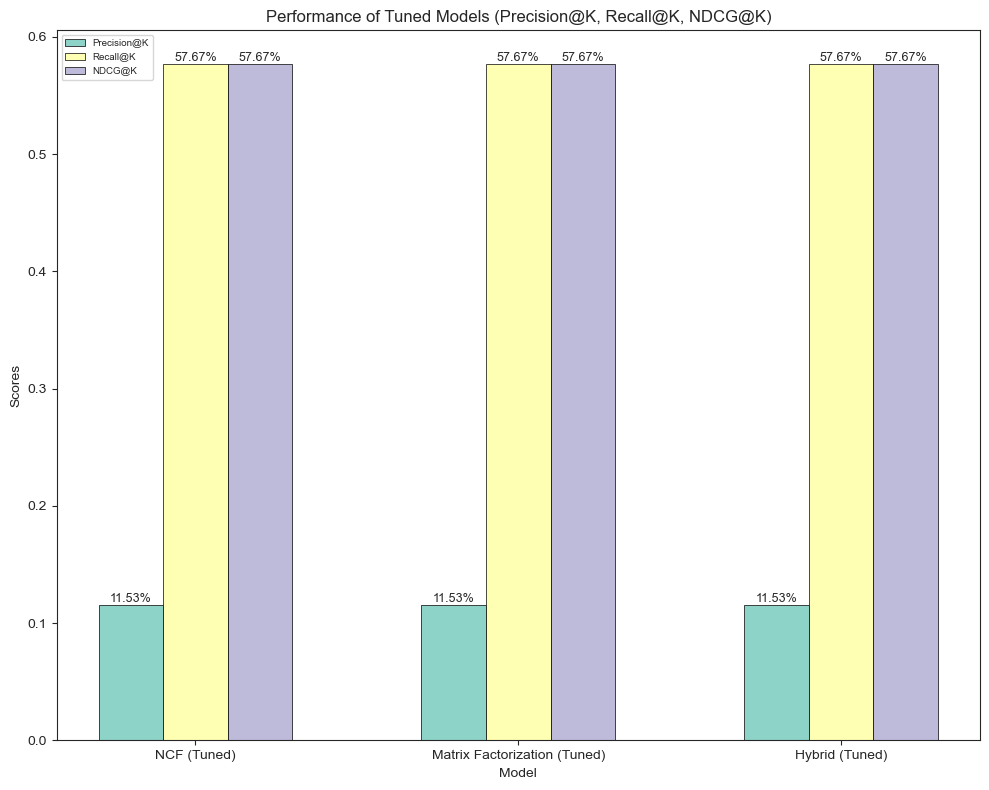

In [553]:
#Use the lists of ranking metrics from the stored results
precision_scores = precision_list_tuned
recall_scores = recall_list_tuned
ndcg_scores = ndcg_list_tuned

#Define the models
models = ['NCF (Tuned)', 'Matrix Factorization (Tuned)', 'Hybrid (Tuned)']

#Set the width of the bars
bar_width = 0.2

#Set the position of the bars on the x-axis
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

#Set colors
colors = sns.color_palette("Set3", 3)

#Grouped bar plot depicting model ranking metric scores
plt.figure(figsize=(10, 8))
bars_precision = plt.bar(r1, precision_scores, color=colors[0], width=bar_width, edgecolor='black', linewidth=0.5, label='Precision@K')
bars_recall = plt.bar(r2, recall_scores, color=colors[1], width=bar_width, edgecolor='black', linewidth=0.5, label='Recall@K')
bars_ndcg = plt.bar(r3, ndcg_scores, color=colors[2], width=bar_width, edgecolor='black', linewidth=0.5, label='NDCG@K')

#Function to format ranking scores as percentages for annotations
def format_scores_as_percent(scores):
    return [f"{score * 100:.2f}%" for score in scores]

#Add annotations just above bars for Precision@K, Recall@K, and NDCG@K scores
def add_labels(bars, scores):
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.0001, score, ha='center', va='bottom', fontsize=9)

#Annotate the bars with percentage format
add_labels(bars_precision, format_scores_as_percent(precision_scores))
add_labels(bars_recall, format_scores_as_percent(recall_scores))
add_labels(bars_ndcg, format_scores_as_percent(ndcg_scores))

#Configure plot
plt.xlabel('Model')
plt.ylabel('Scores')
plt.xticks([r + bar_width for r in range(len(models))], models, ha='center')
plt.title('Performance of Tuned Models (Precision@K, Recall@K, NDCG@K)')

#Reduce the font size of the legend
plt.legend(fontsize=7)

plt.tight_layout()
plt.show()